### 이미지 분류 모델 PKL 만들기 개선버전

- 수업 시간에 만들었던 PKL 모델을 그대로 사용해도 되지만
- 더 개선된 이미지 분류 모델을 만들고 싶거나
- 만드는데 실패한 친구들을 위한 코랩 파일입니다.
- 이 코랩 내용을 잘 따라서 PKL 파일을 만들고
- Github와 Streamlit을 활용한 이미지 분류 웹서비스를 만들어보세요!!

#### 1. 프로그래밍 라이브러리 설치

* 모델 제작을 위한 라이브러리(프로그래밍 도구) 설치 부분입니다.
* 차근차근 천천히 하나씩 녹색 체크표시 확인하며 따라하시고
* 누르라는 권한 설정도 잘눌러주세요

In [ ]:
#fastai 라이브러리 설치
!pip install fastai

In [ ]:
#한글 폰트 처리를 위한 라이브러리 설치
!pip install koreanize-matplotlib

In [ ]:
#fastbook 라이브러리 설치 및 불러오기
#실행이 안되면 다시 실행할 것~

!pip install -Uqq fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.0 MB/s eta 0:00:00


In [ ]:
#코드가 드라이브에 접근할 수 있도록 허용해주는 코드
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# fastbook 라이브러리에서 모든 도구들을 가져온다
# fastai.viwison.widgets에서 모든 도구들을 가져온다.
# 한글 폰트 처리를 위한 도구를 가져온다.

import fastbook
from fastbook import *
from fastai.vision.widgets import *
import koreanize_matplotlib

#### 2. 데이터 수집

* 이미지 분류를 위한 라벨(객관식 정답)을 설정하고 이에 따른 데이터를 수집해
* 여러분의 구글 드라이브에 저장해봅시다
*  https://beausty23.tistory.com/115

In [ ]:
#파이썬 데이터 수집 도구 icrawler 설
!pip install icrawler

In [ ]:
#도구 불러오기

from icrawler.builtin import GoogleImageCrawler, BingImageCrawler
from icrawler.downloader import ImageDownloader
from pathlib import Path
import os

In [ ]:
# 분류할 type(이미지 분류에서 사용할 보기)을 key_types에 문자열로 저장한다.
#key_types에 '' 쌍은 필요에 따라 늘려도 됩니다.

key_types = '구자욱','최원태','이승엽'

# 드라이브에 사진을 저장할 기본 폴더를 만든 후 이를 경로로 지정한다
path = Path('/content/drive/MyDrive/삼성 선수 분류')

# 만약 path에 저장된 경로가 없으면 경로를 만들어준다
if not path.exists() :
  path.mkdir()

In [ ]:
#이름 재설정을 위한 함수 정의
from pathlib import Path

def add_prefix_to_files(dest, prefix):
    """
    지정된 폴더(dest) 안의 모든 파일 이름 앞에 접두사(prefix)를 붙입니다.
    이미 접두사가 붙은 파일은 자동으로 건너뜁니다.
    """
    dest = Path(dest)
    if not dest.exists() or not dest.is_dir():
        print(f"⚠️ {dest} 폴더가 존재하지 않습니다.")
        return

    count = 0
    for file in dest.iterdir():
        if file.is_file():
            if file.name.startswith(prefix):
                # 이미 접두사가 붙은 파일은 건너뜀
                continue
            new_name = prefix + file.name
            new_path = dest / new_name
            file.rename(new_path)
            count += 1
            print(f"{file.name} → {new_name}")

    print(f"\n✅ 총 {count}개의 파일에 접두사 '{prefix}'를 추가했습니다.")

In [ ]:
#Bing 이름 설정을 위한 이동 함수

import shutil
from pathlib import Path

def move_images_and_delete_temp(temp_dir, dest_dir):
    """
    temp_dir 안의 모든 이미지를 dest_dir로 이동한 후 temp_dir을 삭제합니다.
    """
    temp = Path(temp_dir)
    dest = Path(dest_dir)

    # 경로 검증
    if not temp.exists() or not temp.is_dir():
        print(f"⚠️ '{temp}' 폴더가 존재하지 않습니다.")
        return
    dest.mkdir(parents=True, exist_ok=True)

    # 이동한 파일 수 카운트
    moved_count = 0

    # temp 폴더 내 파일 순회
    for file in temp.iterdir():
        if file.is_file():
            # 파일을 dest로 이동 (덮어쓰기 방지)
            target_path = dest / file.name
            shutil.move(str(file), str(target_path))
            moved_count += 1
            print(f"📦 {file.name} → {target_path}")

    # temp 폴더가 비었으면 삭제
    if not any(temp.iterdir()):
        temp.rmdir()
        print(f"🗑️ '{temp}' 폴더를 삭제했습니다.")
    else:
        # 혹시 하위 폴더나 숨김파일이 남아 있을 경우
        shutil.rmtree(temp)
        print(f"🧹 '{temp}' 폴더 전체를 강제로 삭제했습니다.")

    print(f"\n✅ 총 {moved_count}개의 파일을 '{dest}'로 이동 완료.")






In [ ]:
#o라는 이름으로 key_type을 돌면서 이미지 저장힉
#구글 버전

for o in key_types :
  print(path, o) # 확인용
  dest = (path/o) #각각의 키워드에 따라 사진을 저장할 폴더 경로
  print(dest) # 확인용
  dest.mkdir(exist_ok = True) #폴더가 없으면 폴더를 만들고
  google_crawler = GoogleImageCrawler(storage={'root_dir': dest}, feeder_threads=1,parser_threads=1,downloader_threads=4)
  google_crawler.crawl(keyword=o, max_num=200) #파일을 저장할 때 패턴 지정
  add_prefix_to_files(dest,f"Google_{o}")



In [ ]:
#o라는 이름으로 key_type을 돌면서 이미지 저장힉
#빙버전
temp = "/content/temp"
dest.mkdir(exist_ok = True)

for o in key_types :
  print(path, o) # 확인용
  dest = (path/o) #각각의 키워드에 따라 사진을 저장할 폴더 경로
  print(dest) # 확인용
  dest.mkdir(exist_ok = True) #폴더가 없으면 폴더를 만들고
  bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': temp})
  bing_crawler.crawl(keyword=o, filters=None, offset=0, max_num=200)
  add_prefix_to_files(temp,f"Bing_{o}")
  move_images_and_delete_temp(temp, dest)



#### 3. 데이터 전처리하기

* AI 지도학습인 분류를 위해서는
* 데이터에 대한 라벨(문제에 대한 정답)을 잘 설정하는 것이 중요합니다.
* 다음 링크를 눌러 구글 드라이브에 접속한 후 https://drive.google.com/drive/my-drive?hl=ko
* path에 있는 폴더에 들어가서
* 학습에 적합하지 않은 데이터는 고른 후 마우스 오른쪽을 눌러 휴지통으로 이동으로
* 데이터 전처리를 수행해주세요


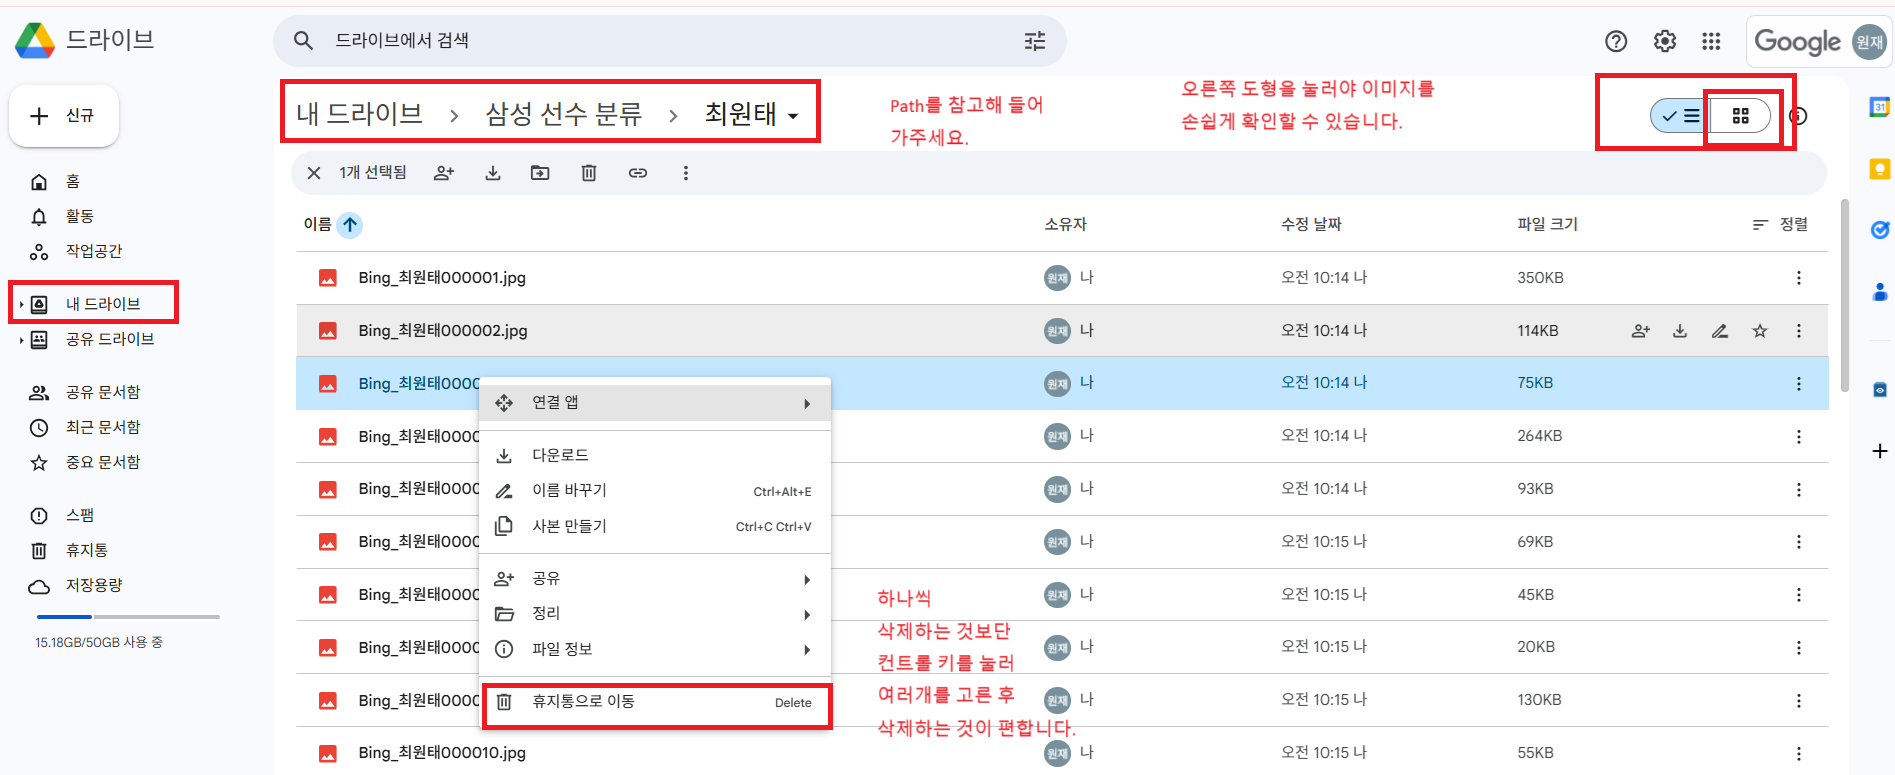

#### 4. 모델 제작하기

* 모델 학습을 위한 기본 환경을 설정한 후
* 모델의 학습 방법을 골라 모델을 제작한 후
* 모델을 여러분의 구글 드라이브에 저장하면 드디어 제작이 끝납니다!!

In [ ]:
typetools = DataBlock(blocks = (ImageBlock, CategoryBlock), #독립변수(데이터), 종속변수(데이터의 정답)
                   get_items = get_image_files, #파일 경로 설정
                   splitter = RandomSplitter(valid_pct =0.2  , seed = 42 ), #검증 파일 비율 20% 랜덤, seed값 난수 고정(42), 20%는 공부하는데 쓰이는게 아니라 테스트하는데 사용됨. -> 본인이 생각하고 수정해도 됨
                   get_y = parent_label, #파일이 저장된 폴더명을 레이블로 사용
                   item_tfms = Resize(128)) #사이즈 통일

#typetools에는 학습을 위한 기본 조건이 들어간다. (공부법)

In [ ]:
#공부법에 실제 데이터를 적용한다
#예) 50분 공부하고 10분 쉬고 암기로 공부하는 방법을 -> 영어단어에 적용한다.

dls = typetools.dataloaders(path) #공부방법.dataloaders(공부과목)

In [ ]:
# @title
import ipywidgets as widgets
from fastai.vision.all import *
from IPython.display import display, clear_output


# --- 1. 사용자가 요청한 모델 리스트 ---

# 1.1. 드롭다운에 표시될 모델 이름 (문자열)
model_names = [
    "resnet18", "resnet34", "resnet50", "resnet101", "resnet152",
    "squeezenet1_0", "squeezenet1_1",
    "densenet121", "densenet169", "densenet201", "densenet161",
    "vgg16_bn", "vgg19_bn",
    "alexnet"
]

# 1.2. 선택된 문자열(예: "resnet18")을 실제 fastai 함수(예: resnet18)로 연결
# 이 부분은 vision_learner에 함수를 전달하기 위해 필수입니다.
MODEL_FUNCTIONS = {
    "resnet18": resnet18,
    "resnet34": resnet34,
    "resnet50": resnet50,
    "resnet101": resnet101,
    "resnet152": resnet152,
    "squeezenet1_0": squeezenet1_0,
    "squeezenet1_1": squeezenet1_1,
    "densenet121": densenet121,
    "densenet169": densenet169,
    "densenet201": densenet201,
    "densenet161": densenet161,
    "vgg16_bn": vgg16_bn,
    "vgg19_bn": vgg19_bn,
    "alexnet": alexnet
}

# --- 2. 위젯 생성 ---

# 2.1. 모델 선택 드롭다운
model_dropdown = widgets.Dropdown(
    options=model_names,
    value='resnet18',
    description='모델 선택:'
)

# 2.2. 학습 횟수(Epoch) 선택 드롭다운 (1~20회)
epoch_dropdown = widgets.Dropdown(
    options=list(range(1, 21)),
    value=5,
    description='학습 횟수:'
)

# 2.3. 학습 실행 버튼
train_button = widgets.Button(
    description="학습 실행",
    button_style='success',
    icon='play'
)

# 2.4. 학습 로그(결과)를 표시할 출력 영역
output_area = widgets.Output()

# --- 3. 버튼 클릭 시 실행될 함수 정의 ---

def run_training(button):
    global learn
    # output_area에 출력을 집중시킵니다.
    with output_area:
        clear_output(wait=True) # 이전 출력을 지웁니다.

        # 1. 드롭다운에서 현재 선택된 값 가져오기
        selected_name = model_dropdown.value
        selected_epochs = epoch_dropdown.value

        # 2. 선택된 모델 이름(문자열)을 실제 함수로 변환
        selected_model_func = MODEL_FUNCTIONS[selected_name]

        print(f"--- 학습 시작 ---")
        print(f"모델: {selected_name}, 학습 횟수: {selected_epochs}")

        try:
            # 3. 사용자가 요청한 핵심 코드 실행
            # learn = vision_learner(dls, resnet18, metrics=error_rate)
            learn = vision_learner(dls, selected_model_func, metrics=error_rate)

            # 4. 사용자가 요청한 핵심 코드 실행
            # learn.fine_tune(5)
            learn.fine_tune(selected_epochs)

            print(f"\n--- 학습 완료 ---")

        except Exception as e:
            print(f"\n[오류] 학습 중 문제가 발생했습니다: {e}")
            # dls가 정의되지 않았을 때 흔히 오류가 발생합니다.
            if 'dls' not in globals():
                print("-> [확인] 'dls' 변수가 정의되지 않은 것 같습니다.")

# --- 4. 위젯과 함수 연결 및 표시 ---

# 버튼(train_button)을 클릭하면 run_training 함수가 실행됩니다.
train_button.on_click(run_training)

# 위젯들을 화면에 순서대로 표시합니다.
display(model_dropdown, epoch_dropdown, train_button, output_area)

In [ ]:
#오차행렬 표시

#분류 학습의 결과를 시각적으로 보여주는 오차행렬을 생성한 후 보여준다.
interp = ClassificationInterpretation.from_learner(learn) #괄호 안에 모델 이름 집어넣기
interp.plot_confusion_matrix()

#### 5. 모델 파일로 내보내기

* 4에서 진행한 모델의 성능이 떨어진다면 2로 돌아가서 이미지의 갯수를 최대 1000까지 늘려서 다시 실행해보거나
* 전처리 수행하고
* 4에서 진행한 모델 학습 환경을 재설정해봅시다.
* 마무리해도 된다고 생각한다면 아래 과정을 따라서
* PKL 파일을 생성해봅시다~
* 구글 드라이브 접속 후 https://drive.google.com/drive/my-drive?hl=ko
* 생성한 PKL 파일을 오른쪽 눌러 공유권한 설정해주세요!!


In [ ]:
#학습한 모델의 정보를 파일로 생성하기 확장자 .pkl

learn.export('')

###